In [ ]:
!pip install pgmpy

     |████████████████████████████████| 1.9 MB 18.5 MB/s 
     |████████████████████████████████| 1.9 MB 37.6 MB/s 
     |████████████████████████████████| 9.8 MB 29.2 MB/s 
     |████████████████████████████████| 233 kB 33.0 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd
from pgmpy.estimators import PC, HillClimbSearch
import networkx as nx
from pgmpy.estimators import BicScore , MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.models import BayesianNetwork
import numpy as np
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG


/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv("data/processed.csv")
print(df.shape)
df.head()

(9709, 12)


,Gender,Own_car,Own_property,Unemployed,Num_family,Account_length,Total_income,Age,Income_type,Education_type,Family_status,Target
0,1,1,1,0,2,1y-2y,high,30-39,Working,Higher education,Civil marriage,1
1,1,1,1,0,2,2y-3y,low,50-59,Working,Secondary / secondary special,Married,0
2,0,0,1,0,1,<1y,high,50-59,Commercial associate,Secondary / secondary special,Single / not married,0
3,0,0,1,1,1,1y-2y,high,60>=,Pensioner,Higher education,Separated,0
4,1,1,1,0,2,<1y,high,40-49,Working,Higher education,Married,0


Working for n conditional variables: 6: 100%|██████████| 6/6 [02:18<00:00, 23.11s/it]


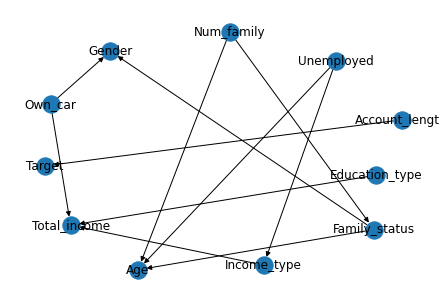

In [ ]:
# PC trial
pcest = PC(df)
pcmodel = pcest.estimate(max_cond_vars=6, significance_level=0.02)
nx.draw(pcmodel, with_labels=True)

  0%|          | 15/1000000 [00:04<84:20:57,  3.29it/s]
-94112.14568490697


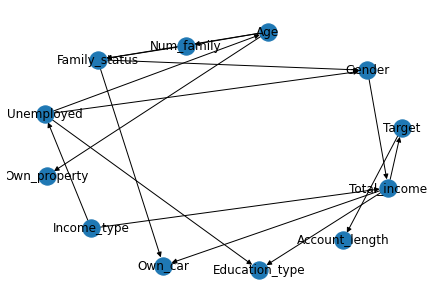

In [ ]:
# first naive trial
hillclimbest = HillClimbSearch(df)
bic_score = BicScore(df)
hillclimbmodel = hillclimbest.estimate(scoring_method=bic_score, fixed_edges=[("Total_income", "Target"), ("Income_type", "Total_income")], black_list=[("Own_car","Gender"), ("Gender", "Own_car")])
nx.draw(hillclimbmodel, with_labels=True) 
print(bic_score.score(hillclimbmodel))

In [ ]:
print(df.columns)

Index(['Gender', 'Own_car', 'Own_property', 'Unemployed', 'Num_family',
       'Account_length', 'Total_income', 'Age', 'Income_type',
       'Education_type', 'Family_status', 'Target'],
      dtype='object')


In [ ]:

print(np.unique(df["Family_status"]))
print(np.unique(df["Income_type"]))
print(np.unique(df['Education_type']))

['Civil marriage' 'Married' 'Separated' 'Single / not married' 'Widow']
['Commercial associate' 'Pensioner' 'State servant' 'Student' 'Working']
['Academic degree' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Secondary / secondary special']


Synthax: attr_string: child_string 

'Gender':

'Own_car': 
 
'Own_property':
  
'Unemployed': 
   
'Num_children':

'Num_family': 'Num_children'
       
'Account_length':

'Total_income': Own_property, Own_car, 'Target'
 
'Age': 'Total_income', 'Income_type', 'Account_length'
 
'Income_type': 'Total_income', 'Unemployed'

'Education_type': 'Unemployed', 'Income_type'

'Family_status': 'Num_family'

'Target':

  0%|          | 8/1000000 [00:01<62:11:29,  4.47it/s]
-94398.62792483842


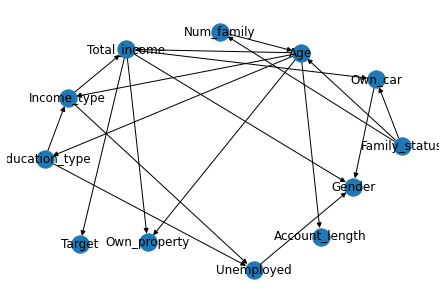

In [ ]:
hillclimbmodel_improved = hillclimbest.estimate(scoring_method=bic_score, fixed_edges=[
    ("Total_income", "Target"), 
    ("Income_type", "Total_income"),
    ("Total_income", "Own_property"),
    ("Total_income", "Own_car"),
    ("Income_type", "Unemployed"),
    ("Age", "Total_income"),
    ("Age", "Income_type"),
    ("Age", "Account_length"),
    ("Income_type", "Total_income"),
    ("Income_type", "Unemployed"),
    ("Education_type", "Unemployed"),
    ("Education_type", "Income_type"),
    ("Family_status", "Num_family")])#, black_list=[("Own_car","Gender"), ("Gender", "Own_car")])
nx.draw(hillclimbmodel_improved, with_labels=True)

print(bic_score.score(hillclimbmodel_improved))

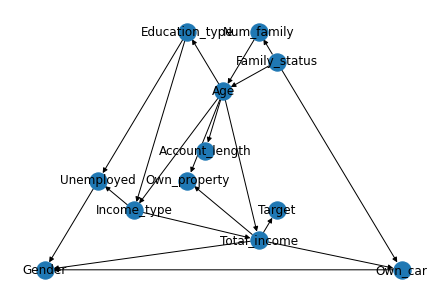

In [ ]:
nx.draw_planar(hillclimbmodel_improved, with_labels=True)

In [ ]:
bnet = BayesianNetwork(hillclimbmodel_improved.edges())
bnet.fit(df, estimator=MaximumLikelihoodEstimator)
cpds = bnet.get_cpds()

for elem in cpds:
    print(elem)

+---------------+-----+----------------------+
| Family_status | ... | Family_status(Widow) |
+---------------+-----+----------------------+
| Total_income  | ... | Total_income(medium) |
+---------------+-----+----------------------+
| Own_car(0)    | ... | 0.8396946564885496   |
+---------------+-----+----------------------+
| Own_car(1)    | ... | 0.16030534351145037  |
+---------------+-----+----------------------+
+--------------+-----+----------------------+
| Own_car      | ... | Own_car(1)           |
+--------------+-----+----------------------+
| Total_income | ... | Total_income(medium) |
+--------------+-----+----------------------+
| Unemployed   | ... | Unemployed(1)        |
+--------------+-----+----------------------+
| Gender(0)    | ... | 0.5619834710743802   |
+--------------+-----+----------------------+
| Gender(1)    | ... | 0.4380165289256198   |
+--------------+-----+----------------------+
+----------------+-----+
| Education_type | ... |
+----------------+---

In [ ]:
bnet = BayesianNetwork(hillclimbmodel_improved.edges())
bnet.fit(df, estimator=BayesianEstimator)
cpds = bnet.get_cpds()

for elem in cpds:
    print(elem)

+---------------+-----+----------------------+
| Family_status | ... | Family_status(Widow) |
+---------------+-----+----------------------+
| Total_income  | ... | Total_income(medium) |
+---------------+-----+----------------------+
| Own_car(0)    | ... | 0.8388324873096447   |
+---------------+-----+----------------------+
| Own_car(1)    | ... | 0.1611675126903553   |
+---------------+-----+----------------------+
+--------------+--------------------+-----+----------------------+
| Own_car      | Own_car(0)         | ... | Own_car(1)           |
+--------------+--------------------+-----+----------------------+
| Total_income | Total_income(high) | ... | Total_income(medium) |
+--------------+--------------------+-----+----------------------+
| Unemployed   | Unemployed(0)      | ... | Unemployed(1)        |
+--------------+--------------------+-----+----------------------+
| Gender(0)    | 0.6652535139133898 | ... | 0.561770761839396    |
+--------------+--------------------+----

In [ ]:
print(cpds[0].variables)
print(cpds[0].values)

['Own_car', 'Family_status', 'Total_income']
[[[0.54411765 0.82381616 0.67815483]
  [0.44542665 0.72103402 0.60174717]
  [0.62708018 0.87224265 0.75673077]
  [0.61887173 0.82858415 0.748297  ]
  [0.83088235 0.91482966 0.83883249]]

 [[0.45588235 0.17618384 0.32184517]
  [0.55457335 0.27896598 0.39825283]
  [0.37291982 0.12775735 0.24326923]
  [0.38112827 0.17141585 0.251703  ]
  [0.16911765 0.08517034 0.16116751]]]


In [ ]:


infer = VariableElimination(bnet)
print(infer.query(['Num_family'], evidence={'Target':0}))

Eliminating: Total_income: 100%|██████████| 5/5 [00:00<00:00, 179.80it/s]+----------------+-------------------+
| Num_family     |   phi(Num_family) |
+================+===================+
| Num_family(1)  |            0.2006 |
+----------------+-------------------+
| Num_family(2)  |            0.5337 |
+----------------+-------------------+
| Num_family(3)  |            0.1684 |
+----------------+-------------------+
| Num_family(4+) |            0.0973 |
+----------------+-------------------+



In [ ]:
from pgmpy.estimators.CITests import chi_square

ordered_list_of_attr = ["Gender", "Age", "Family_status", "Num_family", 
                        "Education_type", "Income_type", "Unemployed", 
                        "Total_income", "Own_property", "Own_car", "Account_length", "Target"]
col_names = df.columns 

p_values = np.zeros((len(col_names), len(col_names)))
for first_index, first_col_val in enumerate(col_names): 
    for second_index, second_col_val in enumerate(col_names):
        if first_index != second_index:
            (chi, p_value, dof) = chi_square(first_col_val, second_col_val, [], df, False)
            p_values[first_index, second_index] = p_value 

display(pd.DataFrame(p_values, columns=col_names, index=col_names)>0.01)
corr = pd.DataFrame(p_values, columns=col_names, index=col_names)
# maggiore = accettiamo = True = Indipendenti
for i in range(len(ordered_list_of_attr)):
    c = ordered_list_of_attr[i]
    for j in range(i+1, len(ordered_list_of_attr)):
        r = ordered_list_of_attr[j]    
        if corr[c][r]<0.01:
            print([c , "->",r])

,Gender,Own_car,Own_property,Unemployed,Num_family,Account_length,Total_income,Age,Income_type,Education_type,Family_status,Target
Gender,False,False,False,False,False,True,False,False,False,True,False,True
Own_car,False,False,True,False,False,False,False,False,False,False,False,True
Own_property,False,True,False,False,True,True,True,False,False,True,False,False
Unemployed,False,False,False,False,False,True,False,False,False,False,False,True
Num_family,False,False,True,False,False,False,True,False,False,False,False,True
Account_length,True,False,True,True,False,False,True,False,False,True,False,False
Total_income,False,False,True,False,True,True,False,False,False,False,False,True
Age,False,False,False,False,False,False,False,False,False,False,False,False
Income_type,False,False,False,False,False,False,False,False,False,False,False,True
Education_type,True,False,True,False,False,True,False,False,False,False,False,True


['Gender', '->', 'Age']
['Gender', '->', 'Family_status']
['Gender', '->', 'Num_family']
['Gender', '->', 'Income_type']
['Gender', '->', 'Unemployed']
['Gender', '->', 'Total_income']
['Gender', '->', 'Own_property']
['Gender', '->', 'Own_car']
['Age', '->', 'Family_status']
['Age', '->', 'Num_family']
['Age', '->', 'Education_type']
['Age', '->', 'Income_type']
['Age', '->', 'Unemployed']
['Age', '->', 'Total_income']
['Age', '->', 'Own_property']
['Age', '->', 'Own_car']
['Age', '->', 'Account_length']
['Age', '->', 'Target']
['Family_status', '->', 'Num_family']
['Family_status', '->', 'Education_type']
['Family_status', '->', 'Income_type']
['Family_status', '->', 'Unemployed']
['Family_status', '->', 'Total_income']
['Family_status', '->', 'Own_property']
['Family_status', '->', 'Own_car']
['Family_status', '->', 'Account_length']
['Num_family', '->', 'Education_type']
['Num_family', '->', 'Income_type']
['Num_family', '->', 'Unemployed']
['Num_family', '->', 'Own_car']
['Num_fam

In [ ]:
display(pd.DataFrame(p_values, columns=col_names, index=col_names).apply(np.log))

,Gender,Own_car,Own_property,Unemployed,Num_family,Account_length,Total_income,Age,Income_type,Education_type,Family_status,Target
Gender,-inf,-616.245837,-17.096983,-140.816843,-34.306838,-2.642767,-251.917081,-135.953926,-156.408439,-2.182859,-119.955992,-1.916548
Own_car,-616.245837,-inf,-1.120036,-105.255566,-115.074168,-4.957653,-231.183178,-94.975367,-102.104702,-45.296526,-120.785831,-0.646807
Own_property,-17.096983,-1.120036,-inf,-38.607448,-0.942559,-1.855561,-1.720504,-75.401218,-34.515093,-2.647412,-6.636110,-5.121073
Unemployed,-140.816843,-105.255566,-38.607448,-inf,-284.349571,-1.880717,-185.514546,-inf,-inf,-95.578866,-222.627612,-4.156378
Num_family,-34.306838,-115.074168,-0.942559,-284.349571,-inf,-6.483826,-4.083536,-inf,-263.218627,-8.488100,-inf,-0.488970
Account_length,-2.642767,-4.957653,-1.855561,-1.880717,-6.483826,-inf,-3.403564,-44.705565,-5.788770,-0.243947,-15.158806,-27.701160
Total_income,-251.917081,-231.183178,-1.720504,-185.514546,-4.083536,-3.403564,-inf,-134.040988,-248.902894,-225.978093,-10.546587,-0.634457
Age,-135.953926,-94.975367,-75.401218,-inf,-inf,-44.705565,-134.040988,-inf,-inf,-200.761365,-494.049234,-5.911174
Income_type,-156.408439,-102.104702,-34.515093,-inf,-263.218627,-5.788770,-248.902894,-inf,-inf,-164.712017,-203.435712,-0.744493
Education_type,-2.182859,-45.296526,-2.647412,-95.578866,-8.488100,-0.243947,-225.978093,-200.761365,-164.712017,-inf,-37.841776,-2.266519


In [ ]:
for el in ["Num_family", "Education_type", "Income_type", "Unemployed", "Total_income", "Own_property", "Account_length", "Target"]:
    (chi, p_value, dof) = chi_square("Family_status",el , ["Gender", "Age"], df, False)
    print(p_value)

["Age", "Family_status", "Num_family", "Education_type", "Income_type", "Unemployed", "Total_income", "Own_property", "Account_length", "Target"]

# ammaccabanane

0.0
1.3464912716254496e-05
0.16167806742425594
0.013261977027760663
0.15312954257534905
0.8019186419658744
0.008693379855200023
0.00044030169612441217


['Age',
 'Family_status',
 'Num_family',
 'Education_type',
 'Income_type',
 'Unemployed',
 'Total_income',
 'Own_property',
 'Account_length',
 'Target']

In [ ]:
edges = [ 
    ("Gender","Total_income"),
    ("Age","Education_type"),
    ("Age","Income_type"),
    ("Age","Family_status"),
    ("Age","Account_length"),
    ("Family_status","Num_family"),
    ("Family_status","Own_property"),
    ("Family_status","Own_car"),
    ("Num_family", "Target"),
    ("Education_type","Income_type"),
    ("Education_type","Unemployed"),
    ("Income_type","Unemployed"),
    ("Income_type","Total_income"),
    ("Unemployed","Target"),
    ("Unemployed","Total_income"),
    ("Total_income", "Own_property"),
    ("Total_income", "Own_car"),
    ("Total_income", "Target"),
    ("Own_property","Target"),
    ("Own_car","Target"),
    ("Account_length","Target"),
    
]

In [ ]:
hand_net = BayesianNetwork(edges)
hand_net.fit(df, estimator=BayesianEstimator)
cpds = hand_net.get_cpds()

for elem in cpds:
    print(elem)

NameError: name 'BayesianNetwork' is not defined

In [ ]:
bic_score = BicScore(df)
print(bic_score.score(hand_net))

-97467.50847894179


In [ ]:
from pgmpy.inference import VariableElimination

infer_hand = VariableElimination(hand_net)
print(infer_hand.query(['Target', 'Income_type'], evidence={'Unemployed': 1, 'Own_property':0, 'Total_income': 'low', 'Own_car':0, 'Account_length': '<1y'}))
print(infer_hand.query(['Total_income'], evidence = {'Income_type':'Student'}))
print(len(df[df["Income_type"] == 'Student']))
print(len(df[(df["Income_type"] == 'Student') & (df["Unemployed"] == 0)]))

Eliminating: Age: 100%|██████████| 5/5 [00:00<00:00, 518.72it/s]
+-----------+-----------------------------------+---------------------------+
| Target    | Income_type                       |   phi(Target,Income_type) |
+===========+===================================+===========================+
| Target(0) | Income_type(Commercial associate) |                    0.0002 |
+-----------+-----------------------------------+---------------------------+
| Target(0) | Income_type(Pensioner)            |                    0.9171 |
+-----------+-----------------------------------+---------------------------+
| Target(0) | Income_type(State servant)        |                    0.0002 |
+-----------+-----------------------------------+---------------------------+
| Target(0) | Income_type(Student)              |                    0.0002 |
+-----------+-----------------------------------+---------------------------+
| Target(0) | Income_type(Working)              |                    0.0002 |

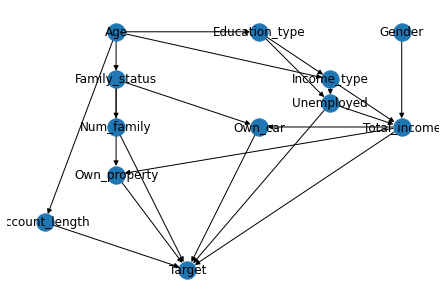

In [ ]:

pos={"Gender":(3,5),
"Age":(1,5),
"Total_income":(3,3),
"Income_type":(2.5,4),
"Education_type":(2,5),
"Num_family":(1,3),
"Account_length":(0.5,1),
"Own_property":(1,2),
"Unemployed":(2.5,3.5),
"Own_car":(2,3),
"Family_status":(1,4),
"Target":(1.5,0),}

nx.draw(hand_net, pos=pos, with_labels=True)
#per ora sto solo mettendo i nomi delle colonne, poi sistemiamo
# sarebbe da fissare la posizione dei nodi
#gender, Age, Family_status, num_family, Education_type, Income_type, Unemployed, Total_income, Own_property, Own_car, Account_length, target
#nx.draw(X, pos)
#plt.show()

In [ ]:
def show_active_trail(net, node_name):
    print(f"The nodes in an active trail that are connected to {node_name} are:")
    to_print = list(net.active_trail_nodes(node_name).values())
    print(to_print)

for elem in df.columns:
    show_active_trail(hand_net, elem)
#eh ma anche io sto bestemmiando per disporre il grafo come si deve

The nodes in an active trail that are connected to Gender are:
[{'Own_car', 'Target', 'Total_income', 'Own_property', 'Gender'}]
The nodes in an active trail that are connected to Own_car are:
[{'Family_status', 'Own_car', 'Total_income', 'Own_property', 'Target', 'Age', 'Income_type', 'Account_length', 'Num_family', 'Education_type', 'Gender', 'Unemployed'}]
The nodes in an active trail that are connected to Own_property are:
[{'Family_status', 'Own_property', 'Total_income', 'Own_car', 'Target', 'Age', 'Income_type', 'Account_length', 'Num_family', 'Education_type', 'Gender', 'Unemployed'}]
The nodes in an active trail that are connected to Unemployed are:
[{'Family_status', 'Own_property', 'Target', 'Total_income', 'Own_car', 'Age', 'Income_type', 'Account_length', 'Education_type', 'Num_family', 'Unemployed'}]
The nodes in an active trail that are connected to Num_family are:
[{'Family_status', 'Own_car', 'Own_property', 'Target', 'Total_income', 'Age', 'Income_type', 'Account_leng

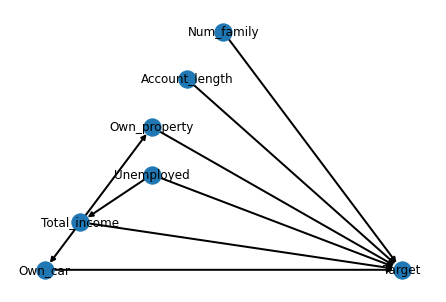

In [ ]:
def draw_markov_blanket(net, node_name):
    filtered_nodes = hand_net.get_markov_blanket(node_name)
    filtered_nodes.append(node_name)
    filtered_edges = [(e1, e2) for (e1, e2) in hand_net.edges() if (e1 in filtered_nodes) and (e2 in filtered_nodes)]

    markov_blanket = DAG()
    markov_blanket.add_nodes_from(nodes=filtered_nodes)
    markov_blanket.add_edges_from(ebunch=filtered_edges)
    nx.draw_planar(markov_blanket, width=2, with_labels=True)

draw_markov_blanket(hand_net, "Target")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=03282642-4d6b-431b-a45f-9f21a6236fff' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>